# Example : DIPSHIFT

In [9]:
# git clone https://github.com/alsinmr/pyRelaxSim.git
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt
RS.Defaults['parallel']=False

In [10]:
%matplotlib notebook

## Build the spin system
For relaxation induced by exchange, we always build the spin system with at least two different sets of interactions. Not all interactions must change, but at least one interaction should be different– otherwise no relaxation will occure. Note that best-practice is to build the first spin-system, and copy it and only edit the parameters that are changed in the second spin-system.

pyRelaxSim takes the main experimental parameters (excepting rf fields) upon initialization of a spin-system, and then interactions are added afterwards.

In [11]:
ex0=RS.ExpSys(v0H=600,vr=2000,Nucs=['13C','1H'],pwdavg=RS.PowderAvg(q=3))     #1-spin system at 600 MHz (14.1 T)
delta=RS.Tools.dipole_coupling(.109,'1H','13C')       #Built-in dipole coupling calculator
ex1=ex0.copy()   #Copies the spin system
ex2=ex0.copy()

S=0.2
tc=1e-10
beta=np.arccos(np.sqrt((2*S+1)/3))

ex0.set_inter(Type='dipole',i0=0,i1=1,delta=delta,euler=[0,beta,0])    #Dipole couplings
ex1.set_inter(Type='dipole',i0=0,i1=1,delta=delta,euler=[0,beta,2/3*np.pi])
ex2.set_inter(Type='dipole',i0=0,i1=1,delta=delta,euler=[0,beta,4/3*np.pi])

## Define Liouvillian, pulse sequence, initial density operator, detection operator

In [12]:
L=RS.Liouvillian((ex0,ex1,ex2))  #Liovillian with both Hamiltonians
N=len(L.H)
kex=(np.ones([N,N])-np.eye(N)*N)/(N*tc)
L.kex=kex

# Calculate the timings. I set this up to have an integer number of cycles
magic=np.arccos(np.sqrt(1/3))
v1pi=62500
tpi=1/v1pi/2

#veff=80000
#tDS=L.taur-tpi/2
#nsteps=int(veff*tDS)
#tstep=tDS/nsteps
#veff=1/tstep
#magic=np.arccos(np.sqrt(1/3))
#v1=veff*np.sin(magic)
#voff=veff*np.cos(magic)

v1=65000
veff=v1/np.sin(magic)
voff=veff*np.cos(magic)
tstep=1/veff
nsteps=int(L.taur/tstep)

t=np.arange(nsteps+1)*tstep
voff=veff*np.cos(magic)*(-1)**np.arange(len(t))
phase=-1*(-1)**np.arange(len(t))*np.pi/2+np.pi/2

seq_homo=RS.Sequence(L)
seq_het=RS.Sequence(L)
seq_ref=RS.Sequence(L)
seq_homo.add_channel('1H',v1=100000,voff=voff,phase=phase,t=t)   #Pulse sequence during homonuclear decoupling
seq_het.add_channel('1H',v1=v1,t=[0,L.taur-tpi/2])  #Pulse sequence during heteronuclear decoupling
seq_ref.add_channel('1H',v1=v1,t=[0,L.taur+tpi/2])  #Pulse sequence during refocusing
seq_ref.add_channel('13C',v1=[v1pi,0,0],t=[0,tpi,tpi/2+L.taur])

<IPython.core.display.Javascript object>


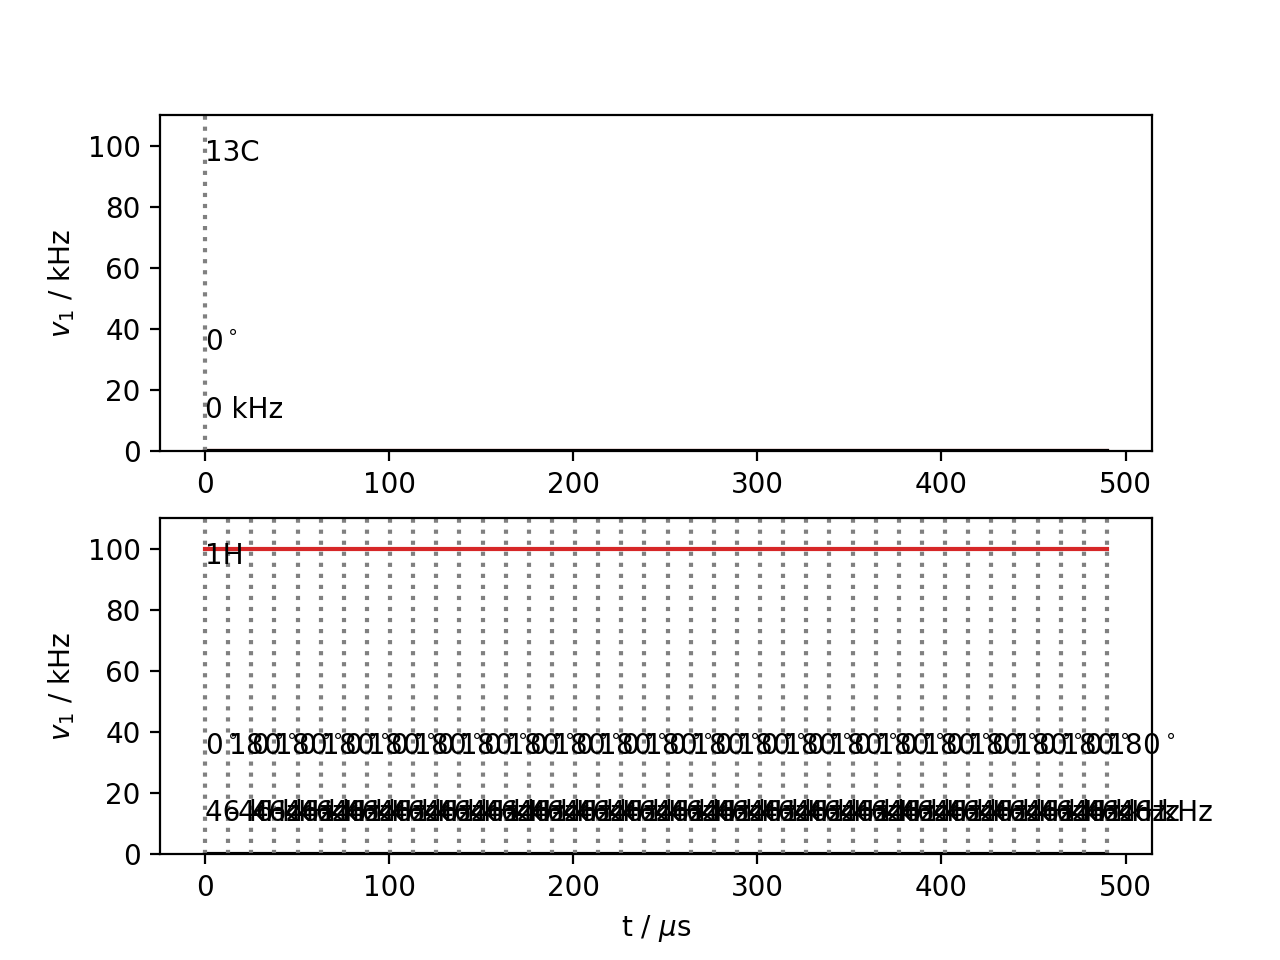

In [13]:
ax=seq_homo.plot(show_ph_off=True)
#ax[0].figure.set_size_inches([8,5])

## Prepare propagators for different parts of the rotor period
Rotor period broken into npts

In [14]:
#L.kex=np.array([[-1e6,1e6],[1e6,-1e6]])*0
npts=17
Dt=(L.taur-tpi/2)/(npts-1)

L.reset_prop_time()
Uhet=list()
for _ in range(npts-1):
    Uhet.append(seq_het.U(Dt=Dt))
L.reset_prop_time()
Uhomo=list()
for _ in range(npts-1):
    Uhomo.append(seq_homo.U(Dt=Dt))
Uref=seq_ref.U()

## Execute the sequence
First prepare the initial density operator and detection operator. Then loop over the time points

In [15]:
Uhet[1].L.Ueye()

Propagator with length of 0.000 microseconds (t0=0.000,tf=0.000)
Constructed from the following Liouvillian:
	Liouvillian under the following conditions:
		2-spin system (13C,1H)
		B0 = 14.092 T (600.000 MHz 1H frequency)
		rotor angle = 54.736 degrees
		rotor frequency = 2.0 kHz
		Temperature = 298 K
		Powder Average: JCP59 with 99 angles
	
	The individual Hamiltonians have the following interactions
		Hamiltonian #0
			dipole between spins 0,1 with arguments:
				(delta=46656.379485364145,euler=[0, 0.818756237602561, 0])
		
		Hamiltonian #1
			dipole between spins 0,1 with arguments:
				(delta=46656.379485364145,euler=[0, 0.818756237602561, 2.0943951023931953])
			Hamiltonian #2
			dipole between spins 0,1 with arguments:
				(delta=46656.379485364145,euler=[0, 0.818756237602561, 4.1887902047863905])
		
	Hamiltonians are coupled by exchange matrix:
		array([[-6.66666667e+09,  3.33333333e+09,  3.33333333e+09],
		       [ 3.33333333e+09, -6.66666667e+09,  3.33333333e+09],
		       [ 3

/opt/anaconda3/lib/python3.8/site-packages/numpy/linalg/linalg.py:2584: RuntimeWarning: overflow encountered in reduce
  ret = add.reduce(abs(x), axis=row_axis).max(axis=col_axis)


<IPython.core.display.Javascript object>


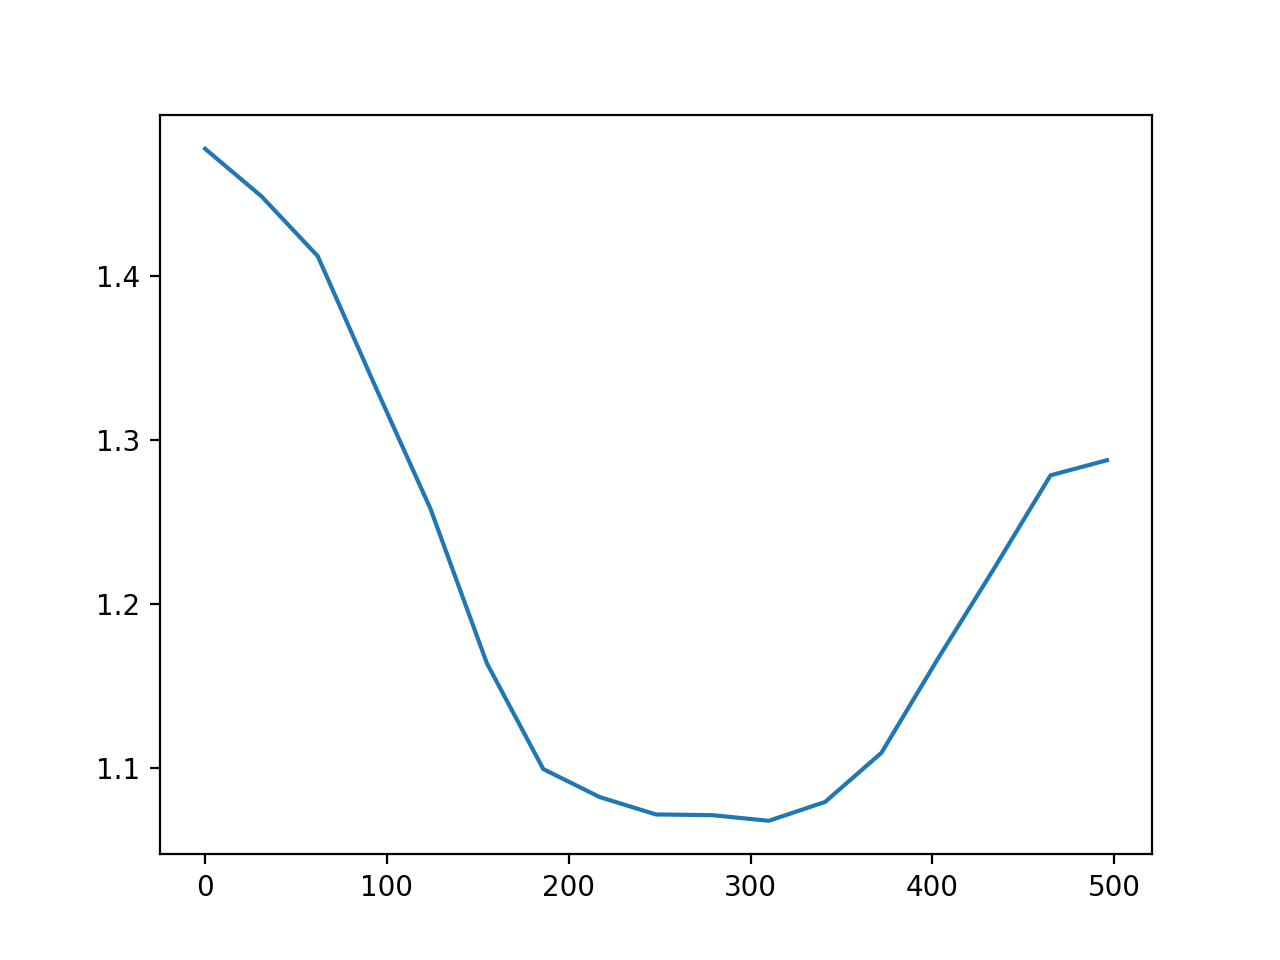

In [16]:
rho=RS.Rho(rho0='13Cx',detect='13Cx')
rho.clear()
for k in range(npts):
    rho.reset()
    for m in range(k):
        Uhomo[m]*rho
    for m in range(k,npts-1):
        Uhet[m]*rho
    Uref*rho
    rho()
ax=plt.figure().add_subplot(111)
#ax.plot(np.arange(npts)*Dt*1e6,rho.I[0].real)
#ax.set_xlabel(r'$t$ / $\mu$s')
ax.plot(np.arange(npts)*Dt*1e6,rho.I[0].real)

In [20]:
Uhomo[0].calculated

False

In [25]:
kex.sum(0)

array([0., 0., 0.])

## Sweep over a range of correlation times

Start by preparing all the propagators

In [29]:
tc0=np.logspace(-8,-2,7)
npts=33
Dt=(L.taur-tpi/2)/(npts-1)
Uhet0=list()
Uhomo0=list()
Uref0=list()
for tc in tc0:
    L.kex=[[-1/(2*tc0),1/(2*tc0)],[1/(2*tc0),-1/(2*tc0)]]

    L.reset_prop_time()
    Uhet0.append(list())
    for _ in range(npts-1):
        Uhet0[-1].append(seq_het.U(Dt=Dt))
    L.reset_prop_time()
    
    Uhomo0.append(list())
    for _ in range(npts-1):
        Uhomo0[-1].append(seq_homo.U(Dt=Dt))
    Uref0.append(seq_ref.U())